In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def swift_voce(strain, alpha, A, epsilon_0, n, k0, Q, beta):
        swift_term = alpha * A * (epsilon_0 + strain) ** n
        voce_term = (1 - alpha) * (k0 + Q * (1 - np.exp(-beta * strain)))
        return swift_term + voce_term


def modified_swift_voce(strain, A, B, n, Q, epsilon0, alpha, beta):
        swift_part = A * (strain + epsilon0) ** n  # Swift law
        voce_part = Q * (1 - np.exp(-B * strain))  # Voce law
        damping = (1 - np.exp(-alpha * strain)) / (1 + beta * strain)  # Damping term
        return swift_part + voce_part * damping

def r_value(strain, c1, c2, c3):
        return c1 + c2 * (1-np.exp(-c3 * strain))


# Normal Swift-Voce fitting

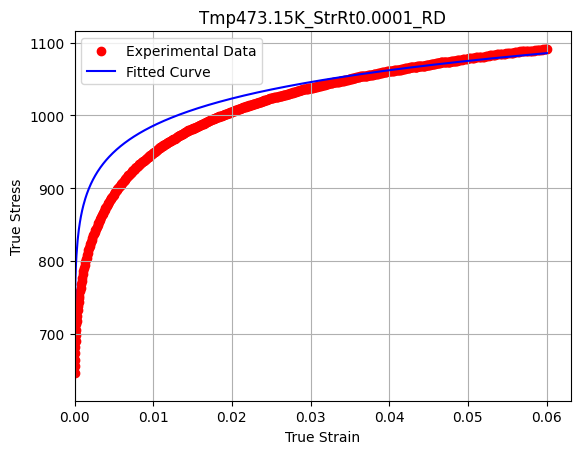

Fitted Parameters:
Alpha: 1.0000
A: 1263.0000
Epsilon_0: 0.0000
n: 0.0538
K0: 429.5828
Q: 117.8428
Beta: 58.0778

Error Metrics:
MSE: 1096.6240
RMSE: 33.1153
MAE: 21.4670
R-squared: 0.8574


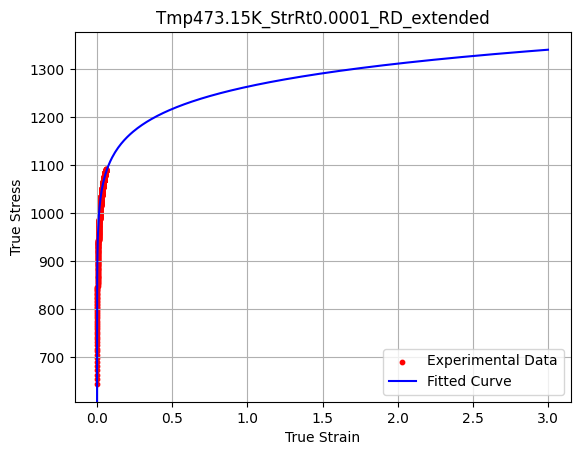

(array([1.00000000e+00, 1.26300000e+03, 1.26239138e-06, 5.38310666e-02,
        4.29582795e+02, 1.17842775e+02, 5.80778328e+01]),
 0       607.945059
 1       773.702620
 2       798.786931
 3       816.321435
 4       829.014796
           ...     
 391    1338.978168
 392    1339.221289
 393    1339.463636
 394    1339.705215
 395    1339.946030
 Name: strain, Length: 396, dtype: float64,
 0      0.00000
 1      0.00011
 2      0.00020
 3      0.00030
 4      0.00040
         ...   
 391    2.96000
 392    2.97000
 393    2.98000
 394    2.99000
 395    3.00000
 Name: strain, Length: 396, dtype: float64)

In [27]:
def analyze_sv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
# Load data in
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values
    
# Initial guesses for parameters [alpha, A, epsilon_0, n, k0, Q, beta]
    initial_guess = [0.5, 900, 0.005, 0.15, 450, 100, 15]
    bounds = ([1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10], [1.0, 1263, 0.02, 0.5, 600, 300, 100])
    weights = 1 / (strain + 0.01) ** 2  # Experiment with the exponent for better fit
    #bounds = ([0, 0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
    
# Fit the curve with bounds
    params, _ = curve_fit(swift_voce, strain, stress, p0=initial_guess, maxfev=10000000, bounds=bounds, sigma=weights)

# Extract fitted parameters
    alpha, A, epsilon_0, n, k0, Q, beta = params

# Plot the experimental data and the fitted curve
    fitted_stress = swift_voce(strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(strain, fitted_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xlim(left=0)
    plt.ylim(bottom=min(fitted_stress))
    plt.show()

# Print fitted parameters
    print(f'Fitted Parameters:\nAlpha: {alpha:.4f}\nA: {A:.4f}\nEpsilon_0: {epsilon_0:.4f}\n'
      f'n: {n:.4f}\nK0: {k0:.4f}\nQ: {Q:.4f}\nBeta: {beta:.4f}\n')
    
# Calculate error metrics
    mse = np.mean((stress - fitted_stress) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(stress - fitted_stress))
    r_squared = 1 - np.sum((stress - fitted_stress) ** 2) / np.sum((stress - np.mean(stress)) ** 2)

    # Print error metrics
    print(f'Error Metrics:\n'
          f'MSE: {mse:.4f}\n'
          f'RMSE: {rmse:.4f}\n'
          f'MAE: {mae:.4f}\n'
          f'R-squared: {r_squared:.4f}')
    
# Extended strain for comparison (you might want to adjust this range)
    extended_strain = pd.read_csv("data/strain_extended.csv")['strain']
    extended_stress = swift_voce(extended_strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red', s=10)
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=min(fitted_stress))
    plt.show()
    
    
    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'Strain': extended_strain,
        'Stress': extended_stress
    })

    # Save the DataFrame to a CSV file
    
    output_file_path = f"extended_curve/new/{title}.csv"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)
    

    return params, extended_stress, extended_strain

condition = 'Tmp473.15K_StrRt0.0001_RD'
analyze_sv_fit(f'data/Exp_FC_StrRtDpn_TmpDpn_Tmp473.csv', condition + '_E', condition + '_S', condition)
   

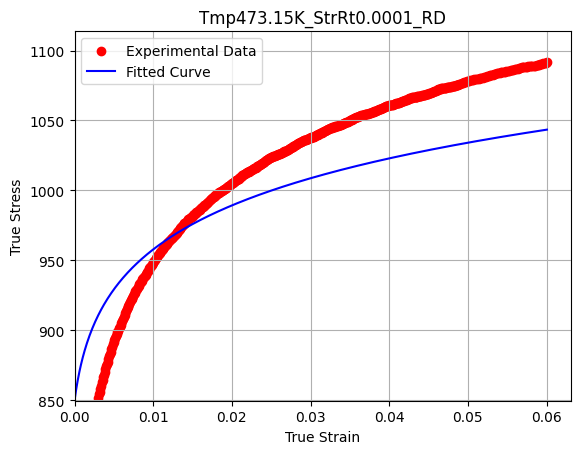

Fitted Parameters:
Alpha: 1.0000
A: 1200.0000
Epsilon_0: 0.0010
n: 0.0500
K0: 400.0000
Q: 150.0000
Beta: 15.0000

Error Metrics:
MSE: 1980.0506
RMSE: 44.4978
MAE: 34.9976
R-squared: 0.7425


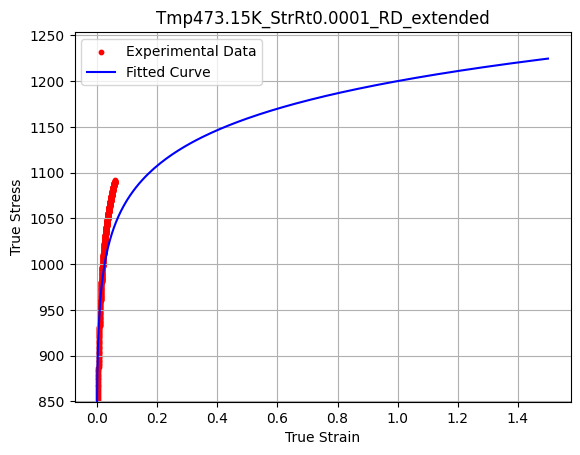

(array([1.0000000e+00, 1.2000000e+03, 1.0000003e-03, 5.0000000e-02,
        4.0000000e+02, 1.5000000e+02, 1.5000000e+01]),
 0       849.534954
 1       853.979412
 2       857.314786
 3       860.752750
 4       863.948097
           ...     
 241    1222.964236
 242    1223.381418
 243    1223.795914
 244    1224.207760
 245    1224.616991
 Name: strain, Length: 246, dtype: float64,
 0      0.00000
 1      0.00011
 2      0.00020
 3      0.00030
 4      0.00040
         ...   
 241    1.46000
 242    1.47000
 243    1.48000
 244    1.49000
 245    1.50000
 Name: strain, Length: 246, dtype: float64)

In [118]:
condition = 'Tmp473.15K_StrRt0.0001_RD'
analyze_sv_fit(f'data/Exp_FC_StrRtDpn_TmpDpn_Tmp473.csv', condition + '_E', condition + '_S', condition)

# Modified Swift-Voce fitting with damping value for high strain

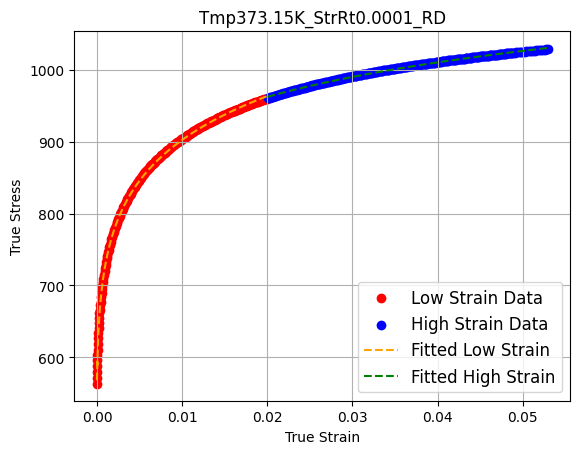

Fitted Parameters for Low Strain (<0.02):
A: 1395.9766, B: 0.0314, n: 0.0949, Q: 115.0833, Epsilon_0: 0.0001, Alpha: 0.0000, Beta: 19.8420
Fitted Parameters for High Strain (>=0.02):
A: 1266.8985, B: 36.5442, n: 0.0703, Q: 4985.3470, Epsilon_0: 0.0000, Alpha: 0.0000, Beta: 19.9989


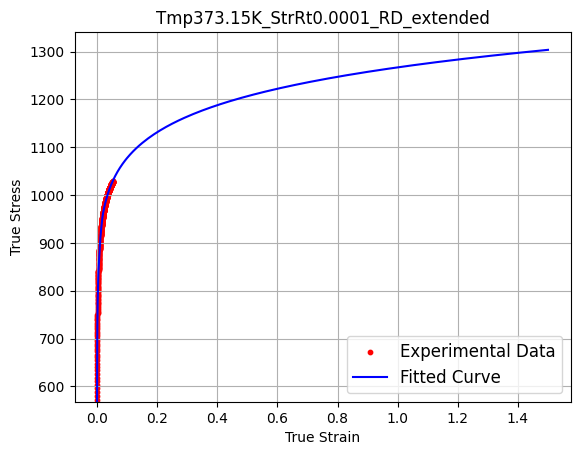

(array([1.39597659e+03, 3.13966383e-02, 9.48876434e-02, 1.15083260e+02,
        7.66198371e-05, 5.80309812e-09, 1.98419524e+01]),
 array([1.26689846e+03, 3.65442473e+01, 7.03059299e-02, 4.98534698e+03,
        5.73760716e-15, 4.62730164e-17, 1.99989100e+01]))

In [80]:
def analyze_msv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
    # Load data
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values
    
    # Initial guesses for parameters [A, B, n, K, epsilon0, alpha, beta]
    if initial_guess is None:
        initial_guess = [1500, 20, 0.2, 2000, 0.02, 0.3, 5] # Default values if not provided
    
    # Adjusted bounds to limit parameter values
    bounds = ([0, 0, 0, 0, 0, 0, 0], [5000, 50, 1, 5000, 0.2, 1, 20])

    # Separate data into low and high strain regions
    low_strain = strain[strain < 0.02]
    low_stress = stress[strain < 0.02]

    high_strain = strain[strain >= 0.02]
    high_stress = stress[strain >= 0.02]

    # Fit the curve for low strain data
    params_low, _ = curve_fit(
        modified_swift_voce, low_strain, low_stress, p0=initial_guess, bounds=bounds
    )

    # Fit the curve for high strain data
    params_high, _ = curve_fit(
        modified_swift_voce, high_strain, high_stress, p0=initial_guess, bounds=bounds
    )

    # Extract fitted stress values
    fitted_low_stress = modified_swift_voce(low_strain, *params_low)
    fitted_high_stress = modified_swift_voce(high_strain, *params_high)

    # Plot experimental and fitted curves
    plt.scatter(low_strain, low_stress, label='Low Strain Data', color='red')
    plt.scatter(high_strain, high_stress, label='High Strain Data', color='blue')
    plt.plot(low_strain, fitted_low_stress, color='orange', linestyle='--', label='Fitted Low Strain')
    plt.plot(high_strain, fitted_high_stress, color='green', linestyle='--', label='Fitted High Strain')
    
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()

    # Print fitted parameters for both regions
    print(f'Fitted Parameters for Low Strain (<0.02):\n'
          f'A: {params_low[0]:.4f}, B: {params_low[1]:.4f}, n: {params_low[2]:.4f}, '
          f'Q: {params_low[3]:.4f}, Epsilon_0: {params_low[4]:.4f}, '
          f'Alpha: {params_low[5]:.4f}, Beta: {params_low[6]:.4f}')

    print(f'Fitted Parameters for High Strain (>=0.02):\n'
          f'A: {params_high[0]:.4f}, B: {params_high[1]:.4f}, n: {params_high[2]:.4f}, '
          f'Q: {params_high[3]:.4f}, Epsilon_0: {params_high[4]:.4f}, '
          f'Alpha: {params_high[5]:.4f}, Beta: {params_high[6]:.4f}')

    extended_strain = pd.read_csv("data/strain_extended.csv")['strain']
    extended_strain = extended_strain[extended_strain <= 1.5]
    low_stress = modified_swift_voce(extended_strain[extended_strain < 0.02], *params_low)
    high_stress = modified_swift_voce(extended_strain[extended_strain >= 0.02], *params_high)
    extended_stress = np.concatenate((low_stress, high_stress))
    plt.scatter(strain, stress, label='Experimental Data', color='red', s=10)
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend(fontsize='large')
    plt.ylim(bottom=min(extended_stress))
    plt.grid(True)
    plt.show()
    
    '''
    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'Strain': extended_strain,
        'Stress': extended_stress
    })

    # Save the DataFrame to a CSV file
    output_file_path = f"extended_curve/{title}.csv"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)
    '''
    return params_low, params_high
   
condition = 'Tmp298.15K_StrRt1_RD'
#condition = 'Tmp473.15K_StrRt0.1_RD'
condition = 'Tmp373.15K_StrRt0.0001_RD'
analyze_msv_fit('data/Exp_FC_StrRtDpn_TmpDpn_Tmp373.csv', condition + '_E', condition + '_S', condition)



# Plot of all strain rate and parameters relationship

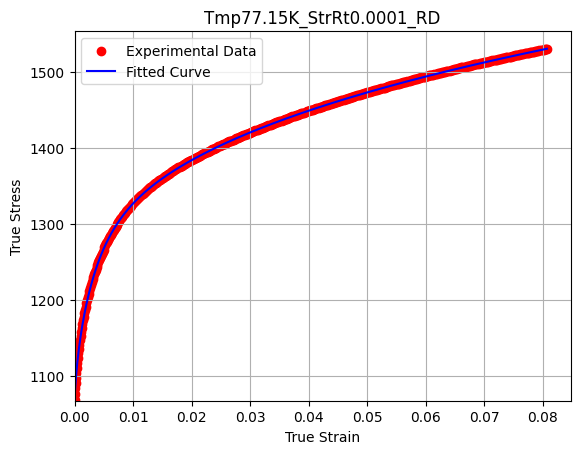

Fitted Parameters:
Alpha: 0.1895
A: 4808.3465
Epsilon_0: 0.0001
n: 0.3083
K0: 1250.4939
Q: 120.1041
Beta: 295.7024

Error Metrics:
MSE: 0.1312
RMSE: 0.3623
MAE: 0.2671
R-squared: 1.0000


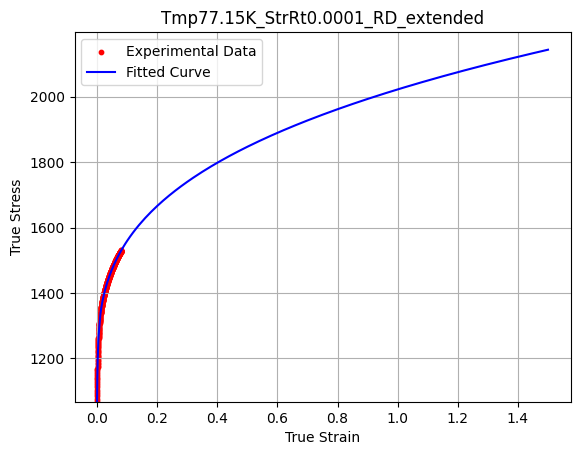

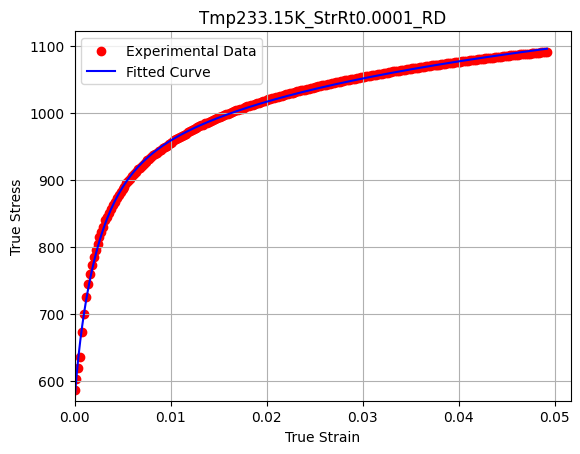

Fitted Parameters:
Alpha: 0.8705
A: 1431.6198
Epsilon_0: 0.0005
n: 0.1016
K0: 0.0000
Q: 1370.1926
Beta: 413.3357

Error Metrics:
MSE: 12.4201
RMSE: 3.5242
MAE: 2.5443
R-squared: 0.9986


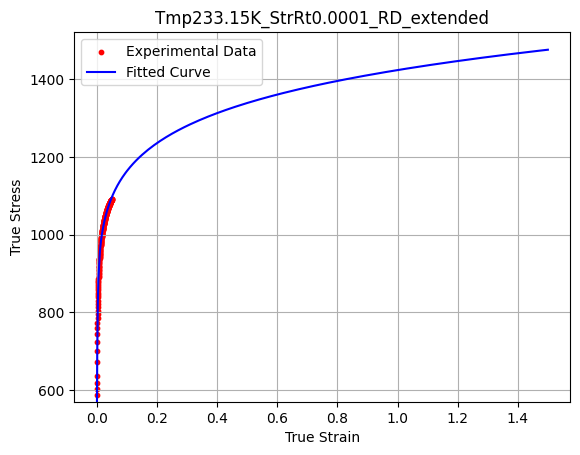

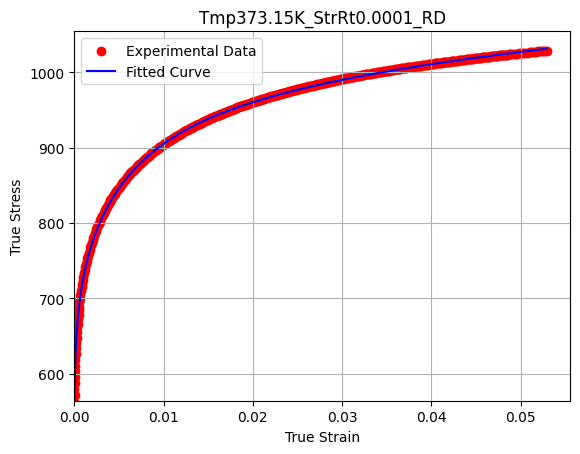

Fitted Parameters:
Alpha: 0.9336
A: 1295.6551
Epsilon_0: 0.0000
n: 0.0762
K0: 0.0000
Q: 961.4682
Beta: 176.9176

Error Metrics:
MSE: 1.9414
RMSE: 1.3933
MAE: 0.9635
R-squared: 0.9998


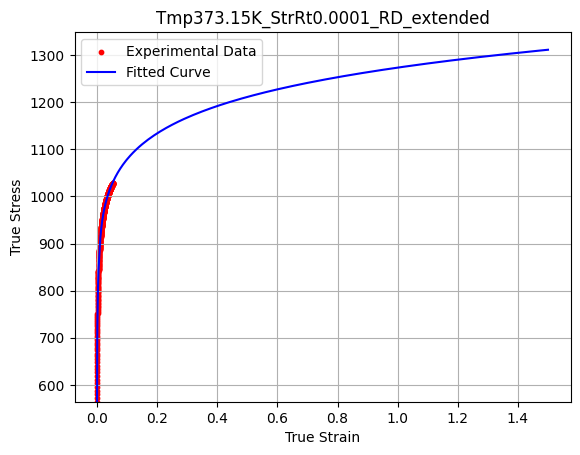

KeyboardInterrupt: 

In [81]:
params = [] #store all parameters
params_name  = ['alpha', 'A', 'epsilon_0', 'n', 'k0', 'Q', 'beta']

conditions_77 = ['Tmp77.15K_StrRt0.0001_RD']
conditions_233 = ['Tmp233.15K_StrRt0.0001_RD']
#conditions_298 = ['Tmp298.15K_StrRt0.0001_RD', 'Tmp298.15K_StrRt0.0001_DD', 'Tmp298.15K_StrRt0.0001_TD', 'Tmp298.15K_StrRt0.001_RD', 'Tmp298.15K_StrRt0.001_DD', 'Tmp298.15K_StrRt0.001_TD', 'Tmp298.15K_StrRt0.01_RD', 'Tmp298.15K_StrRt0.01_DD', 'Tmp298.15K_StrRt0.01_TD', 'Tmp298.15K_StrRt0.1_RD','Tmp298.15K_StrRt0.1_DD', 'Tmp298.15K_StrRt0.1_TD']
conditions_373 = ['Tmp373.15K_StrRt0.0001_RD', 'Tmp373.15K_StrRt0.001_RD', 'Tmp373.15K_StrRt0.01_RD', 'Tmp373.15K_StrRt0.1_RD']
conditions_473 = ['Tmp473.15K_StrRt0.0001_RD', 'Tmp473.15K_StrRt0.001_RD', 'Tmp473.15K_StrRt0.01_RD']
conditions_573 = ['Tmp573.15K_StrRt0.0001_RD', 'Tmp573.15K_StrRt0.001_RD', 'Tmp573.15K_StrRt0.01_RD', 'Tmp573.15K_StrRt0.1_RD']
conditions_673 = ['Tmp673.15K_StrRt0.0001_RD', 'Tmp673.15K_StrRt0.001_RD', 'Tmp673.15K_StrRt0.01_RD', 'Tmp673.15K_StrRt0.1_RD']
conditions = [conditions_77, conditions_233, conditions_373, conditions_473, conditions_573, conditions_673]
temps = ['77', '233', '373', '473', '573', '673']

for i in range(len(conditions)):
    for condition in conditions[i]:
        params.append(analyze_sv_fit(f'data/Exp_FC_StrRtDpn_TmpDpn_Tmp{temps[i]}.csv', condition + '_E', condition + '_S', condition))

# r value fitting and generation

Strain Rate: 0.0001
RD Params: [-3.96879003e-01  1.13149540e+00  3.17251524e+02  7.35030403e-01
  6.95428757e+01 -1.87687147e-02  1.86737289e-01]
DD Params: [ 2.27086898e+02  2.26029608e+01  1.35708342e+02 -2.35464094e+02
  1.41919307e+02 -1.66698301e-02  4.87406825e-01]
TD Params: [ 7.73936126e+01  9.35344114e+00  1.26732771e+02 -8.04421080e+01
  1.32715233e+02 -1.64650286e-02  4.86243304e-01]


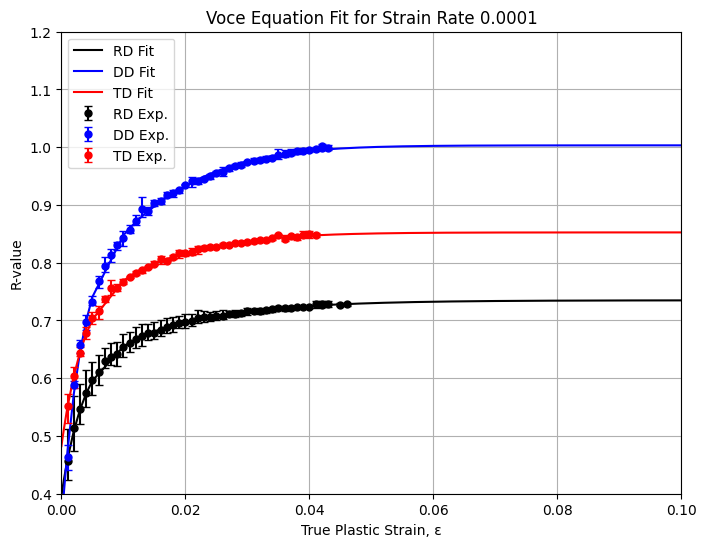

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Define the equation for r-value evolution
def r_value_eq(ε, c1, c2, C3, C4, C5, C6, alpha):
    term1 = alpha * (c1 + c2 * (1 - np.exp(-C3 * np.clip(ε, 0, 1e2))))
    term2 = (1 - alpha) * (C4 / (1 + np.exp(-C5 * (np.clip(ε, 0, 1e2) - C6))))
    return term1 + term2

# Define the residuals function
def residuals(params, strain, r_values):
    return r_value_eq(strain, *params) - r_values

# Load the data
file_path = 'data/Exp_rV_StrRtDpn_Tmp298.csv'  
data = pd.read_csv(file_path)

# Function to process data for the strain rate 0.0001
def process_strain_rate(strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col):
    # Extract data for a specific strain rate
    strain = data[strain_col]
    rd_r_value = data[rd_col]
    dd_r_value = data[dd_col]
    td_r_value = data[td_col]
    
    rd_upper_error = data[rd_u_col]  # Upper error bar for RD
    rd_lower_error = data[rd_l_col]  # Lower error bar for RD
    
    dd_upper_error = data[dd_u_col]  # Upper error bar for DD
    dd_lower_error = data[dd_l_col]  # Lower error bar for DD
    
    td_upper_error = data[td_u_col]  # Upper error bar for TD
    td_lower_error = data[td_l_col]  # Lower error bar for TD

    # Check for NaN or inf values and filter them
    valid_idx_rd = np.isfinite(strain) & np.isfinite(rd_r_value)
    valid_idx_dd = np.isfinite(strain) & np.isfinite(dd_r_value)
    valid_idx_td = np.isfinite(strain) & np.isfinite(td_r_value)

    strain_rd = strain[valid_idx_rd]
    rd_r_value_clean = rd_r_value[valid_idx_rd]
    rd_error_upper_clean = rd_upper_error[valid_idx_rd]
    rd_error_lower_clean = rd_lower_error[valid_idx_rd]

    strain_dd = strain[valid_idx_dd]
    dd_r_value_clean = dd_r_value[valid_idx_dd]
    dd_error_upper_clean = dd_upper_error[valid_idx_dd]
    dd_error_lower_clean = dd_lower_error[valid_idx_dd]

    strain_td = strain[valid_idx_td]
    td_r_value_clean = td_r_value[valid_idx_td]
    td_error_upper_clean = td_upper_error[valid_idx_td]
    td_error_lower_clean = td_lower_error[valid_idx_td]
    
    # Define specific initial guesses for the strain rate 0.0001
    initial_guess = [0.8, 0.1, 20, 0.5, 10, 0.02, 0.5]

    # Use least_squares to perform fitting
    res_rd = least_squares(residuals, initial_guess, args=(strain_rd, rd_r_value_clean))
    res_dd = least_squares(residuals, initial_guess, args=(strain_dd, dd_r_value_clean))
    res_td = least_squares(residuals, initial_guess, args=(strain_td, td_r_value_clean))

    # Generate fitted r-values for the strain range up to 3
    strain_fit = pd.read_csv("data/strain_extended.csv")['strain']
    rd_r_fit = r_value_eq(strain_fit, *res_rd.x)
    dd_r_fit = r_value_eq(strain_fit, *res_dd.x)
    td_r_fit = r_value_eq(strain_fit, *res_td.x)

    # Plot the experimental data with error bars and fitted curves
    plt.figure(figsize=(8, 6))
    
    # Plot RD data with error bars
    plt.errorbar(strain_rd, rd_r_value_clean, 
                 yerr=[rd_error_lower_clean, rd_error_upper_clean], 
                 fmt='o', color='black', label='RD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, rd_r_fit, color='black', label='RD Fit')

    # Plot DD data with error bars
    plt.errorbar(strain_dd, dd_r_value_clean, 
                 yerr=[dd_error_lower_clean, dd_error_upper_clean], 
                 fmt='o', color='blue', label='DD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, dd_r_fit, color='blue', label='DD Fit')

    # Plot TD data with error bars
    plt.errorbar(strain_td, td_r_value_clean, 
                 yerr=[td_error_lower_clean, td_error_upper_clean], 
                 fmt='o', color='red', label='TD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, td_r_fit, color='red', label='TD Fit')

    # Customize the plot
    plt.xlabel('True Plastic Strain, ε')
    plt.ylabel('R-value')
    plt.title(f'Voce Equation Fit for Strain Rate {strain_rate_label}')
    plt.legend()
    plt.grid(True)
    plt.xlim([0, 0.1])  # Adjust the x-axis limits as needed
    plt.ylim([0.4, 1.2])  # Adjust the y-axis limits as needed
    plt.savefig(f'Voce_Equation_Fit_{strain_rate_label}.png', dpi=300)

    # Prepare data for CSV export
    export_data = pd.DataFrame({
        'Strain': strain_fit,
        'RD_R_value': rd_r_fit,
        'DD_R_value': dd_r_fit,
        'TD_R_value': td_r_fit
    })
    
    # Export to CSV
    export_data.to_csv(f'extended_r/R_values_StrainRate_{strain_rate_label}.csv', index=False)

    # Return the final parameters for RD, DD, TD
    return res_rd.x, res_dd.x, res_td.x

# Define strain rate info for 0.0001
strain_rate_info_0001 = (
    '0.0001', 
    'Tmp298.15K_StrRt0.0001_RD_E', 
    'Tmp298.15K_StrRt0.0001_RD_r', 
    'Tmp298.15K_StrRt0.0001_DD_r', 
    'Tmp298.15K_StrRt0.0001_TD_r',
    'Tmp298.15K_StrRt0.0001_RD_U', 
    'Tmp298.15K_StrRt0.0001_RD_L', 
    'Tmp298.15K_StrRt0.0001_DD_U', 
    'Tmp298.15K_StrRt0.0001_DD_L', 
    'Tmp298.15K_StrRt0.0001_TD_U', 
    'Tmp298.15K_StrRt0.0001_TD_L'
)

# Process the strain rate 0.0001
rd_params, dd_params, td_params = process_strain_rate(*strain_rate_info_0001)

# Print the fitted parameters
print(f"Strain Rate: {strain_rate_info_0001[0]}")
print(f"RD Params: {rd_params}")
print(f"DD Params: {dd_params}")
print(f"TD Params: {td_params}")

Strain Rate: 0.001
RD Params: [8.20896401e-01 3.23023228e-01 5.00000000e+01 6.67456283e-01
 5.92020398e-13 3.48121818e-05 5.64619869e-01]
DD Params: [ 1.          0.9999799   3.47949733  0.99998253 29.99743112  0.05958232
  0.97240315]
TD Params: [ 1.          0.99943625  1.06738251  1.         29.99999977  0.05944072
  0.71630864]

Strain Rate: 0.01
RD Params: [6.96953836e-01 5.34610621e-01 5.00000000e+01 5.75001038e-01
 1.51754362e-10 2.34861856e-05 5.85179884e-01]
DD Params: [1.00000000e+00 2.93245037e-02 5.00000000e+01 1.00000000e+00
 1.41462786e+01 8.65764319e-10 1.00000000e+00]
TD Params: [1.00000000e+00 2.28012286e-03 5.00000000e+01 1.00000000e+00
 2.46740767e+01 6.52628037e-14 1.00000000e+00]

Strain Rate: 0.1
RD Params: [9.09737223e-01 1.97820578e-13 4.99999998e+01 8.84901471e-01
 3.19641723e-11 8.13590654e-01 6.40434998e-01]
DD Params: [1.00000000e+00 1.29838232e-01 4.99999994e+01 2.13072367e-01
 1.23400550e-03 2.94448191e-10 1.00000000e+00]
TD Params: [1.00000000e+00 1.04298

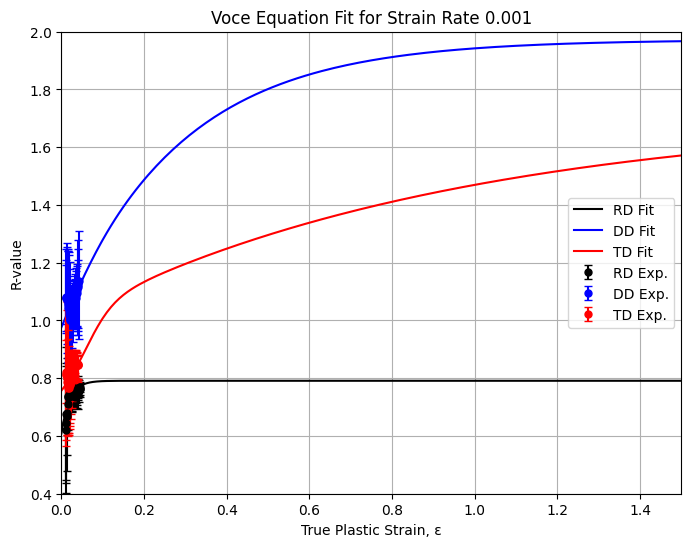

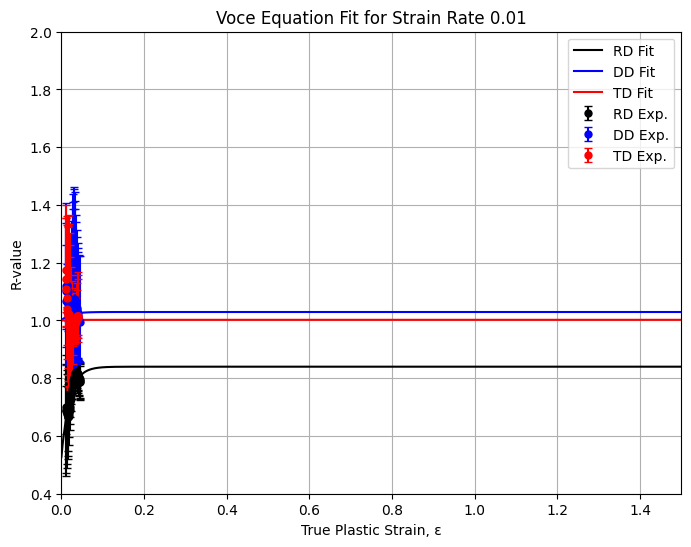

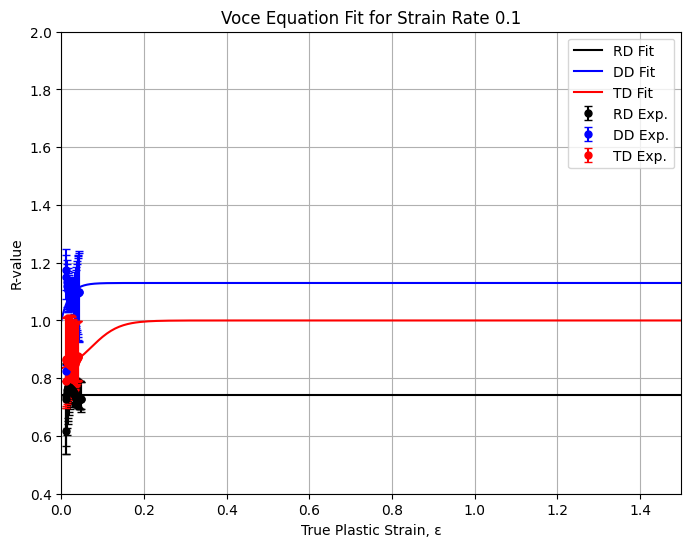

In [ ]:
# Define the residuals function
#def residuals(params, strain, r_values):
#   return r_value_eq(strain, *params) - r_values
def residuals(params, strain, r_values, penalty_weight=100.0):
    r_fit = r_value_eq(strain, *params)
    residuals = r_fit - r_values
    penalty = penalty_weight * (r_fit[-1] - r_values[-1])**2  # penalty term for constant R-value at high strains
    return np.concatenate((residuals, [penalty]))

# Function to process data for each strain rate
def process_strain_rate(strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col):
    # Extract data for a specific strain rate
    strain = data[strain_col].values
    rd_r_value = data[rd_col].values
    dd_r_value = data[dd_col].values
    td_r_value = data[td_col].values
    
    rd_upper_error = data[rd_u_col].values  # Upper error bar for RD
    rd_lower_error = data[rd_l_col].values  # Lower error bar for RD
    
    dd_upper_error = data[dd_u_col].values  # Upper error bar for DD
    dd_lower_error = data[dd_l_col].values  # Lower error bar for DD
    
    td_upper_error = data[td_u_col].values  # Upper error bar for TD
    td_lower_error = data[td_l_col].values  # Lower error bar for TD

    # Check for NaN or inf values and filter them
    valid_idx_rd = np.isfinite(strain) & np.isfinite(rd_r_value)
    valid_idx_dd = np.isfinite(strain) & np.isfinite(dd_r_value)
    valid_idx_td = np.isfinite(strain) & np.isfinite(td_r_value)

    strain_rd = strain[valid_idx_rd]
    rd_r_value_clean = rd_r_value[valid_idx_rd]
    rd_error_upper_clean = rd_upper_error[valid_idx_rd]
    rd_error_lower_clean = rd_lower_error[valid_idx_rd]

    strain_dd = strain[valid_idx_dd]
    dd_r_value_clean = dd_r_value[valid_idx_dd]
    dd_error_upper_clean = dd_upper_error[valid_idx_dd]
    dd_error_lower_clean = dd_lower_error[valid_idx_dd]

    strain_td = strain[valid_idx_td]
    td_r_value_clean = td_r_value[valid_idx_td]
    td_error_upper_clean = td_upper_error[valid_idx_td]
    td_error_lower_clean = td_lower_error[valid_idx_td]
    
    # Define specific initial guesses for each strain rate
    initial_guesses = {
        '0.001': [0.75, 0.35, 20, 0.60, 10, 0.020, 0.5],
        '0.01': [0.65, 0.25, 18, 0.55, 13, 0.025, 0.4],
        '0.1': [0.55, 0.45, 32, 0.90, 7, 0.010, 0.3]
    }

    # Get initial guesses for the parameters
    initial_guess = initial_guesses.get(strain_rate_label, [0.5] * 7)

    # Set bounds for the parameters
    bounds = (
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # Lower bounds
        [1.0, 1.0, 50.0, 1.0, 30.0, 1.0, 1.0]  # Upper bounds
    )

    # Attempt to fit the data
    res_rd = least_squares(residuals, initial_guess, args=(strain_rd, rd_r_value_clean), bounds=bounds)
    res_dd = least_squares(residuals, initial_guess, args=(strain_dd, dd_r_value_clean), bounds=bounds)
    res_td = least_squares(residuals, initial_guess, args=(strain_td, td_r_value_clean), bounds=bounds)

    # Generate fitted r-values for the strain range up to 3
    strain_fit = pd.read_csv("data/strain_extended.csv")['strain']
    rd_r_fit = r_value_eq(strain_fit, *res_rd.x)
    dd_r_fit = r_value_eq(strain_fit, *res_dd.x)
    td_r_fit = r_value_eq(strain_fit, *res_td.x)

    # Plot the experimental data with error bars and fitted curves
    plt.figure(figsize=(8, 6))
    
    # Plot RD data with error bars
    plt.errorbar(strain_rd, rd_r_value_clean, 
                 yerr=[rd_error_lower_clean, rd_error_upper_clean], 
                 fmt='o', color='black', label='RD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, rd_r_fit, color='black', label='RD Fit')

    # Plot DD data with error bars
    plt.errorbar(strain_dd, dd_r_value_clean, 
                 yerr=[dd_error_lower_clean, dd_error_upper_clean], 
                 fmt='o', color='blue', label='DD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, dd_r_fit, color='blue', label='DD Fit')

    # Plot TD data with error bars
    plt.errorbar(strain_td, td_r_value_clean, 
                 yerr=[td_error_lower_clean, td_error_upper_clean], 
                 fmt='o', color='red', label='TD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, td_r_fit, color='red', label='TD Fit')

    # Customize the plot
    plt.xlabel('True Plastic Strain, ε')
    plt.ylabel('R-value')
    plt.title(f'Voce Equation Fit for Strain Rate {strain_rate_label}')
    plt.legend()
    plt.grid(True)
    plt.xlim([0, 1.5])  # Adjusting the x-axis limits
    plt.ylim([0.4, 2])  # Adjusting the y-axis limits
    plt.savefig(f'Voce_Equation_Fit_{strain_rate_label}.png', dpi=300)
    
    # Prepare data for CSV export
    export_data = pd.DataFrame({
        'Strain': strain_fit,
        'RD_R_value': rd_r_fit,
        'DD_R_value': dd_r_fit,
        'TD_R_value': td_r_fit
    })
    
    # Export to CSV
    export_data.to_csv(f'extended_r/R_values_StrainRate_{strain_rate_label}.csv', index=False)
    
    # Return the final parameters for RD, DD, TD
    return res_rd.x, res_dd.x, res_td.x

# Process each strain rate
strain_rate_info = [
    ('0.001', 'Tmp298.15K_StrRt0.001_RD_E', 'Tmp298.15K_StrRt0.001_RD_r', 'Tmp298.15K_StrRt0.001_DD_r', 'Tmp298.15K_StrRt0.001_TD_r',
     'Tmp298.15K_StrRt0.001_RD_U', 'Tmp298.15K_StrRt0.001_RD_L', 'Tmp298.15K_StrRt0.001_DD_U', 'Tmp298.15K_StrRt0.001_DD_L', 'Tmp298.15K_StrRt0.001_TD_U', 'Tmp298.15K_StrRt0.001_TD_L'),
    ('0.01', 'Tmp298.15K_StrRt0.01_RD_E', 'Tmp298.15K_StrRt0.01_RD_r', 'Tmp298.15K_StrRt0.01_DD_r', 'Tmp298.15K_StrRt0.01_TD_r',
     'Tmp298.15K_StrRt0.01_RD_U', 'Tmp298.15K_StrRt0.01_RD_L', 'Tmp298.15K_StrRt0.01_DD_U', 'Tmp298.15K_StrRt0.01_DD_L', 'Tmp298.15K_StrRt0.01_TD_U', 'Tmp298.15K_StrRt0.01_TD_L'),
    ('0.1', 'Tmp298.15K_StrRt0.1_RD_E', 'Tmp298.15K_StrRt0.1_RD_r', 'Tmp298.15K_StrRt0.1_DD_r', 'Tmp298.15K_StrRt0.1_TD_r',
     'Tmp298.15K_StrRt0.1_RD_U', 'Tmp298.15K_StrRt0.1_RD_L', 'Tmp298.15K_StrRt0.1_DD_U', 'Tmp298.15K_StrRt0.1_DD_L', 'Tmp298.15K_StrRt0.1_TD_U', 'Tmp298.15K_StrRt0.1_TD_L')
]

# Loop through strain rates and print fitted parameters
for strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col in strain_rate_info:
    rd_params, dd_params, td_params = process_strain_rate(strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col)
    
    # Check if parameters are returned successfully
    if rd_params is not None and dd_params is not None and td_params is not None:
        print(f"Strain Rate: {strain_rate_label}")
        print(f"RD Params: {rd_params}")
        print(f"DD Params: {dd_params}")
        print(f"TD Params: {td_params}\n")
    else:
        print(f"Failed to fit parameters for strain rate {strain_rate_label}.\n")


# Calculating ratio between RD, TD, DD, biaxial and generate files for stress-strain simulation

In [28]:
directions = ['RD', 'DD', 'TD']
ref_temp = '298.15'

strain_rates = [0.0001]
temps = ['77.15', '233.15']

strain_rates = [0.0001, 0.001, 0.01, 0.1]
temps = ['298.15', '373.15', '473.15', '573.15', '673.15']

strain_rates = [0.0001]
temps = ['473.15']

#RD-biaxial ratio from Zinan file
data_biax = pd.read_csv('data/strain_extended.csv')
ratio_biax = data_biax['biaxial']/data_biax['RD']

for strain_rate in strain_rates:
    data_RD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv')
    data_DD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_DD.csv')
    data_TD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_TD.csv')
    r = pd.read_csv(f'extended_r/R_values_StrainRate_{strain_rate}.csv')
    
    #RD-DD and RD-TD ratio
    ratio = [data_DD['Stress']/data_RD['Stress'], data_TD['Stress']/data_RD['Stress'], ratio_biax]

    #Generate TD, DD, biaxial for all conditions
    for temp in temps:
        #Read in RD data
        temp_RD = pd.read_csv(f'extended_curve/new/Tmp{temp}K_StrRt{strain_rate}_RD.csv')['Stress']
        
        df = pd.DataFrame({
        'strain': data_RD['Strain'],
        'RD': temp_RD,
        'DD': temp_RD * ratio[0],
        'TD': temp_RD * ratio[1],
        'biaxial': temp_RD * ratio[2],
        'r_RD': r['RD_R_value'],
        'r_DD': r['DD_R_value'],
        'r_TD': r['TD_R_value']
    })

        # Save the DataFrame to a CSV file
        output_file_path = f"inp_file/new/Tmp{temp}K_StrRt{strain_rate}.csv"  # Adjust the filename as needed
        df.to_csv(output_file_path, index=False)

In [ ]:
strain_rate = 1
ref_strain_rate = 0.1
temp = '298.15'

data_RD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{ref_strain_rate}_RD.csv')
data_DD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{ref_strain_rate}_DD.csv')
data_TD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{ref_strain_rate}_TD.csv')
r = pd.read_csv(f'extended_r/R_values_StrainRate_{ref_strain_rate}.csv')

#RD-DD and RD-TD ratio
ratio = [data_DD['Stress']/data_RD['Stress'], data_TD['Stress']/data_RD['Stress'], ratio_biax]

temp_RD = pd.read_csv(f'extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')['Stress']

df = pd.DataFrame({
    'strain': data_RD['Strain'],
    'RD': temp_RD,
    'DD': temp_RD * ratio[0],
    'TD': temp_RD * ratio[1],
    'biaxial': temp_RD * ratio[2],
    'r_RD': r['RD_R_value'],
    'r_DD': r['DD_R_value'],
    'r_TD': r['TD_R_value']
})

# Save the DataFrame to a CSV file
output_file_path = f"inp_file/Tmp{temp}K_StrRt{strain_rate}.csv"  # Adjust the filename as needed
df.to_csv(output_file_path, index=False)